# classify-tones

## Visualizations

This Jupyter notebook project illustrates how to plot sine waves of the white keys on a piano from C4 to C5:

- C4 (261.6256 Hz)
- D4 (293.6648 Hz)
- E4 (329.6276 Hz)
- F4 (349.2282 Hz)
- G4 (391.9954 Hz)
- A4 (440.0000 Hz)
- B4 (493.8833 Hz)
- C5 (523.2511 Hz)

All the tones are available in the `Tones` folder as `.wav` files.

In this project, we'll move towards a classification model for these sine waves. First, we should get a good understanding of what our data looks like.

### Visualizing provided tones

Let's take a look the tones provided in the `Tones` folder.

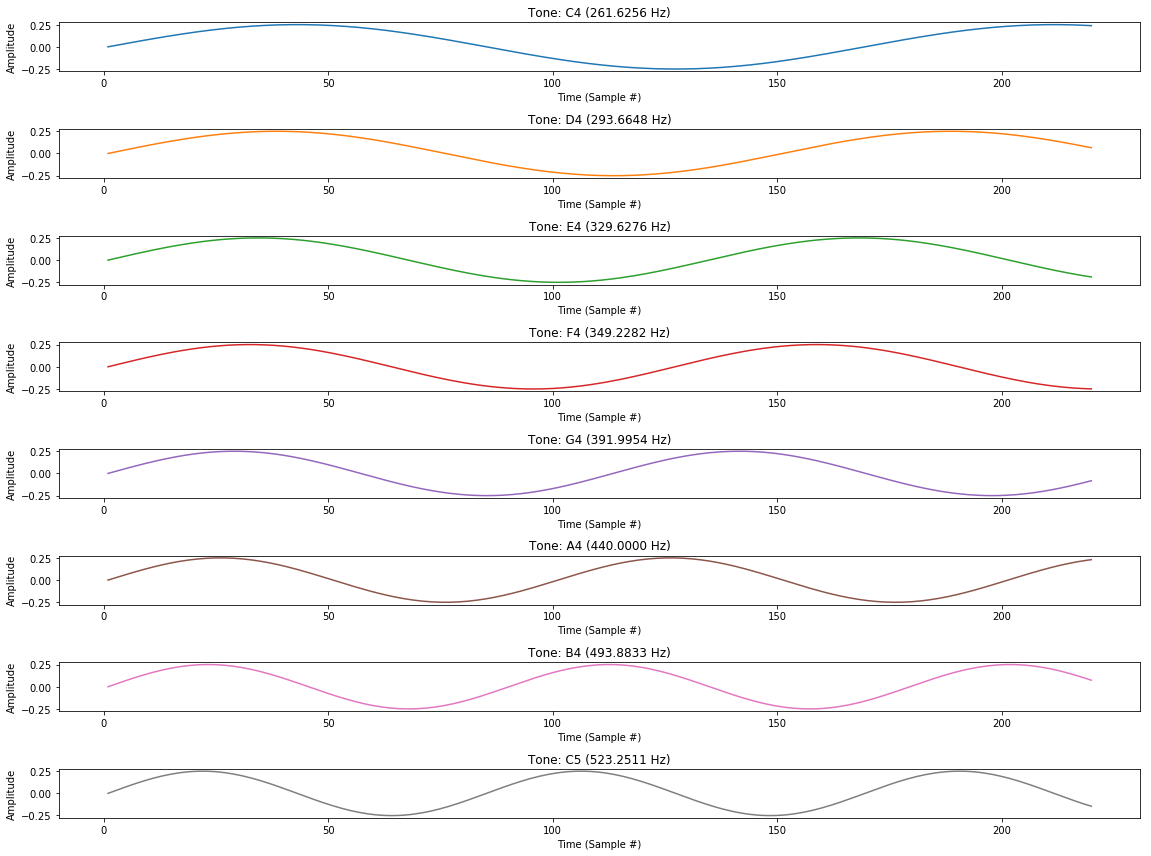

In [70]:
from models import ToneLibrary, Tone
import matplotlib.pyplot as plt

# Encapsulates all the .wav tone files and provides useful meta-data
tone_library = ToneLibrary(directory='Tones')
tone_library.populate()

# Setup Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# We'll use these colors for each of the different tones
# Source: https://stackoverflow.com/a/42091037
plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# We only want to take a look at the first 1% of the wave
sample_ratio = 0.01

_, axes = plt.subplots(len(tone_library), 1, figsize=(16, 12))

for i, tone in enumerate(tone_library):
    
    plt_num_samples = int(tone.num_total_samples * sample_ratio)
    
    # Reduce the signal to only part we want to look at
    x = tone.time[:plt_num_samples]
    y = tone.get_channel(1)[:plt_num_samples]
    
    ax = axes[i]
    ax.plot(x, y, color=plt_colors[i])
    ax.set(title=str(tone), xlabel='Time (Sample #)', ylabel='Amplitude')

plt.tight_layout()

### Visualizations in frequency domain

Taking a look at these Time vs. Amplitude plots isn't too helpful as we move towards a decent classification model for these tones. We'll need to apply a Discrete Fourier transform to translate this data into the frequency domain.

For those who may not be familiar, this GIF illustrates what an FFT does:

<video width="540" height="360" controls loop autoplay>
  <source src="img/FFT animation.mp4" type="video/mp4">
</video>

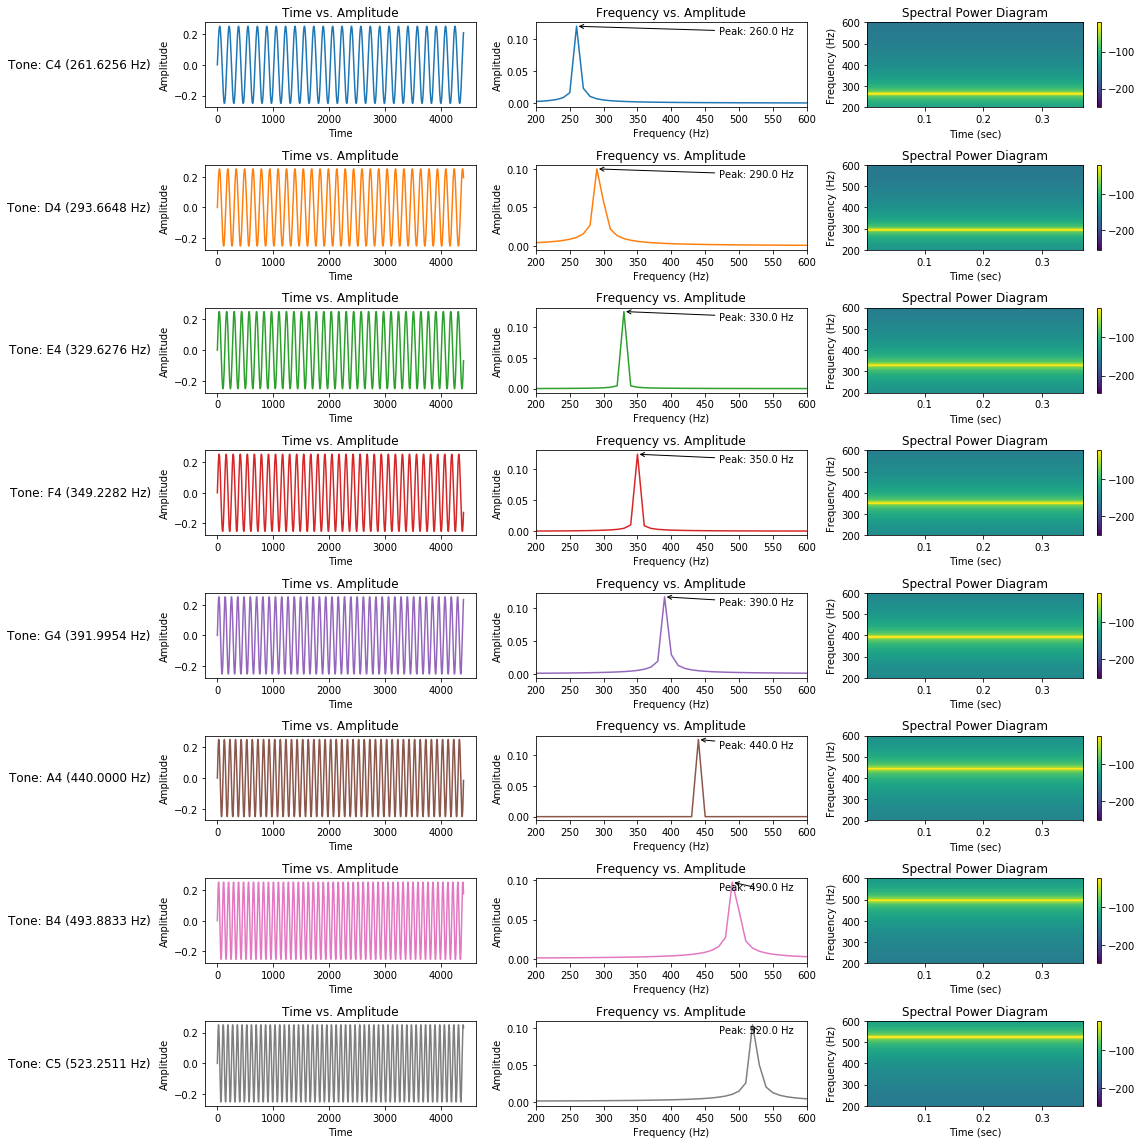

In [77]:
import numpy as np
from utils import fft

fig, axes = plt.subplots(len(tone_library), 3, figsize=(16, 16))

# The range of frequencies that are tones come from
freq_lim = (200, 600)

# How much of the signal we want to use here
sample_ratio = 0.2

for i, tone in enumerate(tone_library):

    plt_color = plt_colors[i]
    
    plt_num_samples = int(tone.num_total_samples * sample_ratio)
    
    # Trim the signal
    time = tone.time[:plt_num_samples]
    signal = tone.get_channel(1)[:plt_num_samples]
    
    # Perform FFT
    fft_freq, fft_y = fft(signal, tone.rate)
    max_fft_y_index = np.argmax(fft_y)
    max_fft_y_value = np.max(fft_y)
    estimated_peak_freq = fft_freq[max_fft_y_index]

    # Add the tone information to the row
    ax = axes[i, 0]
    padding = 5
    ax.annotate(str(tone), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - padding, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
    # Add the Time vs. Amplitude graph
    ax = axes[i, 0]
    ax.plot(time, signal, linestyle='-', color=plt_color)
    ax.set(title='Time vs. Amplitude', xlabel='Time', ylabel='Amplitude')
    
    # Add the Frequency vs. Amplitude graph from FFT
    ax = axes[i, 1]
    ax.plot(fft_freq, fft_y, linestyle='-', color=plt_color)
    ax.set(title='Frequency vs. Amplitude', xlabel='Frequency (Hz)', ylabel='Amplitude', xlim=freq_lim)
    # https://matplotlib.org/gallery/text_labels_and_annotations/annotation_demo.html
    ax.annotate('Peak: %s Hz' % estimated_peak_freq,
                xy=(estimated_peak_freq, max_fft_y_value), xycoords='data',
                xytext=(0.95, 0.95), textcoords='axes fraction',
                arrowprops=dict(arrowstyle='->'),
                horizontalalignment='right', verticalalignment='top')

    # Add the spectrogram
    ax = axes[i, 2]
    _, _, _, im = ax.specgram(tone.get_channel(1), NFFT=16386, Fs=tone.rate)
    ax.set_title('Spectral Power Diagram')
    ax.set(xlabel='Time (sec)', ylabel='Frequency (Hz)', ylim=freq_lim)
    fig.colorbar(im, ax=ax)

plt.tight_layout()

We have a good understanding of what our signals look like. Now that we can extract features from them (like the peak frequency after FFT), we're ready to try out a simple classifier.

### Classifier

We'll use a simple KNN model as our classifier. This pipeline trains our model on the full 0.5 seconds of audio but tests it only on the first 0.1 seconds, or 20%. (I know it's bad practice, but it'll get the job done for now 😁)

In [30]:
# Training data
X_train = [[tone.frequency] for tone in tone_library]
y_train = [tone.scientific_name for tone in tone_library]

# Simple KNN picking the closest matching sample
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# Generate testing data
from utils import sample_tone, estimate_peak_freq

# Get the testing data
X_test = []
y_test = []

for tone in tone_library:
    # Sample 20% of the tone, 0.1 seconds
    t_sample, signal_sample = sample_tone(tone, 0.2)
    
    x = estimate_peak_freq(signal_sample, tone.rate)
    y = tone.scientific_name
    
    X_test.append([x])
    y_test.append(y)

y_predict = knn.predict(X_test)

import pandas as pd
results = pd.DataFrame({
    'Train: Scientific Name': y_train,
    'Train: Frequency (Hz)': [x[0] for x in X_train],
    'Test: Peak Frequency (Hz)': [x[0] for x in X_test],
    'Test: Estimated Scientific Name': y_predict,
    'Is Estimated Frequency Correct?': ['Yes' if prediction == label else 'No' for label, prediction in zip(y_train, y_predict)],
    'Train Frequency - Test Freqency': [train_freq - test_freq for train_freq, test_freq in zip([x[0] for x in X_train], [x[0] for x in X_test])]
})

from IPython.display import HTML
HTML(results.to_html(index=False))

Train: Scientific Name,Train: Frequency (Hz),Test: Peak Frequency (Hz),Test: Estimated Scientific Name,Is Estimated Frequency Correct?,|Train Frequency - Test Freqency|
C4,261.6256,260.0,C4,Yes,1.6256
D4,293.6648,290.0,D4,Yes,3.6648
E4,329.6276,330.0,E4,Yes,-0.3724
F4,349.2282,350.0,F4,Yes,-0.7718
G4,391.9954,390.0,G4,Yes,1.9954
A4,440.0000,440.0,A4,Yes,0.0000
B4,493.8833,490.0,B4,Yes,3.8833
C5,523.2511,520.0,C5,Yes,3.2511


From above, we can see that every instance is classifed correctly using when using `k=1` with out KNN model.

We've developed a semi-decent pipeline for classifying simple tones.